# Download Preprocessed Data
- data preprocessing notebook can be found <a href="https://github.com/PrabhuKiran8790/NLP/blob/main/final-project/nlp_data_preprocessing.ipynb">here</s>

In [1]:
!gdown 1LnnaqpaCk6c7rYCFhibZNsl24h2mPj6x

Downloading...
From: https://drive.google.com/uc?id=1LnnaqpaCk6c7rYCFhibZNsl24h2mPj6x
To: /content/df_cleaned_train_test_val.pkl
100% 2.25M/2.25M [00:00<00:00, 203MB/s]


In [2]:
import pickle

cleaned_data = None
with open('/content/df_cleaned_train_test_val.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

In [3]:
cleaned_data.keys()

dict_keys(['df_train', 'df_test', 'df_val', 'labels'])

In [4]:
df_train = cleaned_data['df_train']
df_test = cleaned_data['df_test']
df_val = cleaned_data['df_val']
labels = cleaned_data['labels']

In [5]:
df_train

,Input,Sentiment
0,I do not feel humiliate,3
1,I can go from feel so hopeless to so damn hope...,3
2,I m grab a minute to post I feel greedy wrong,1
3,I am ever feel nostalgic about the fireplace I...,2
4,I am feel grouchy,1
...,...,...
15995,I just have a very brief time in the beanbag a...,3
15996,I am now turn and I feel pathetic that I am st...,3
15997,I feel strong and good overall,0
15998,I feel like this was such a rude comment and I...,1


In [6]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer

In [7]:
!pip install --upgrade tensorflow_hub -q

In [8]:
df_train_inputs = df_train.Input.tolist()

# BERT
- BERT for embedding

In [9]:
import tensorflow_hub as hub

emb_model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = emb_model(df_train_inputs)
print(embeddings.shape)

(16000, 128)


In [10]:
X_val_emb = emb_model(df_val.Input.tolist())

In [11]:
from keras.utils import to_categorical
y_train = to_categorical(df_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [12]:
num_words = 16000
tokenizer = Tokenizer(num_words,lower=True)
df_total = pd.concat([df_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

In [13]:
from keras_preprocessing.sequence import pad_sequences

X_train = tokenizer.texts_to_sequences(df_train['Input']) # texts -> numeric sequences 
X_train_pad = pad_sequences(X_train, maxlen=300, padding='post') # length of all numeric sequences equal

X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')

X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [14]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Input
import tensorflow as tf
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Dropout

# Model Architecture

In [15]:
EMBEDDING_DIM = 128 # this means the embedding layer will create  a vector in 128 dimension

model = Sequential()
model.add(Embedding(input_dim = num_words, # the whole vocabulary size 
                    output_dim = EMBEDDING_DIM, # vector space dimension
                    input_length= X_train_pad.shape[1], # max_len of text sequence
                    weights = [embeddings],trainable = False))

model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          2048000   
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 200)         184000    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 400)         643200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 300, 400)          0

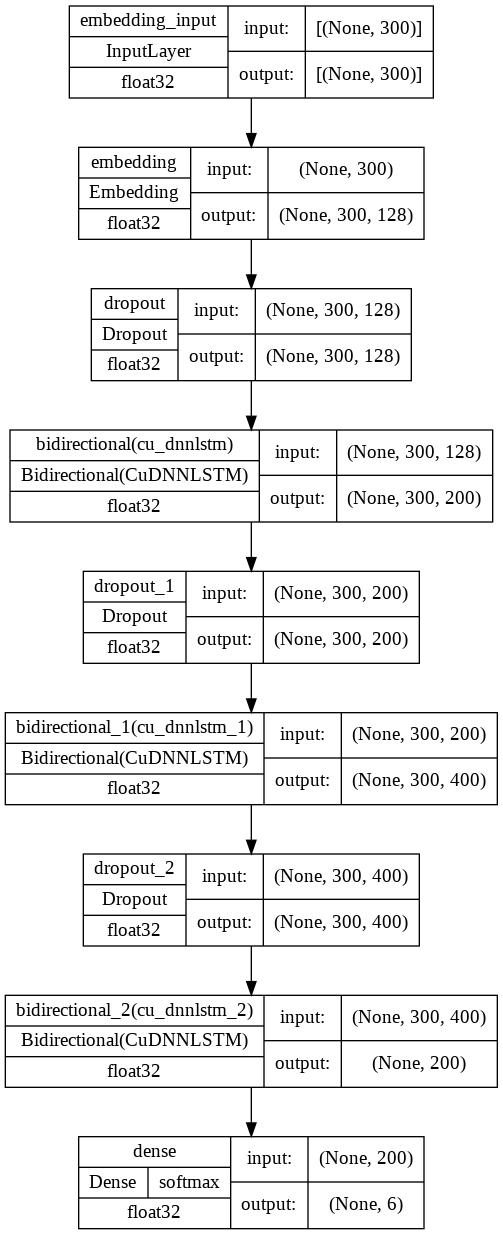

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [49]:
history_embedding = model.fit(X_train_pad,
                              y_train,
                              epochs = 50,
                              batch_size = 128,
                              validation_data=(X_val_pad, y_val),
                              verbose = 1,
                              callbacks=[es, mc])

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8994
Epoch 1: val_accuracy improved from 0.79600 to 0.79750, saving model to ./model.h5
125/125 [==============================] - 24s 193ms/step - loss: 0.2734 - accuracy: 0.8994 - val_loss: 0.6290 - val_accuracy: 0.7975
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9049
Epoch 2: val_accuracy improved from 0.79750 to 0.79800, saving model to ./model.h5
125/125 [==============================] - 24s 193ms/step - loss: 0.2589 - accuracy: 0.9049 - val_loss: 0.6363 - val_accuracy: 0.7980
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9024
Epoch 3: val_accuracy did not improve from 0.79800
125/125 [==============================] - 24s 191ms/step - loss: 0.2589 - accuracy: 0.9024 - val_loss: 0.6890 - val_accuracy: 0.7910
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.90

# Model Performance Visualization

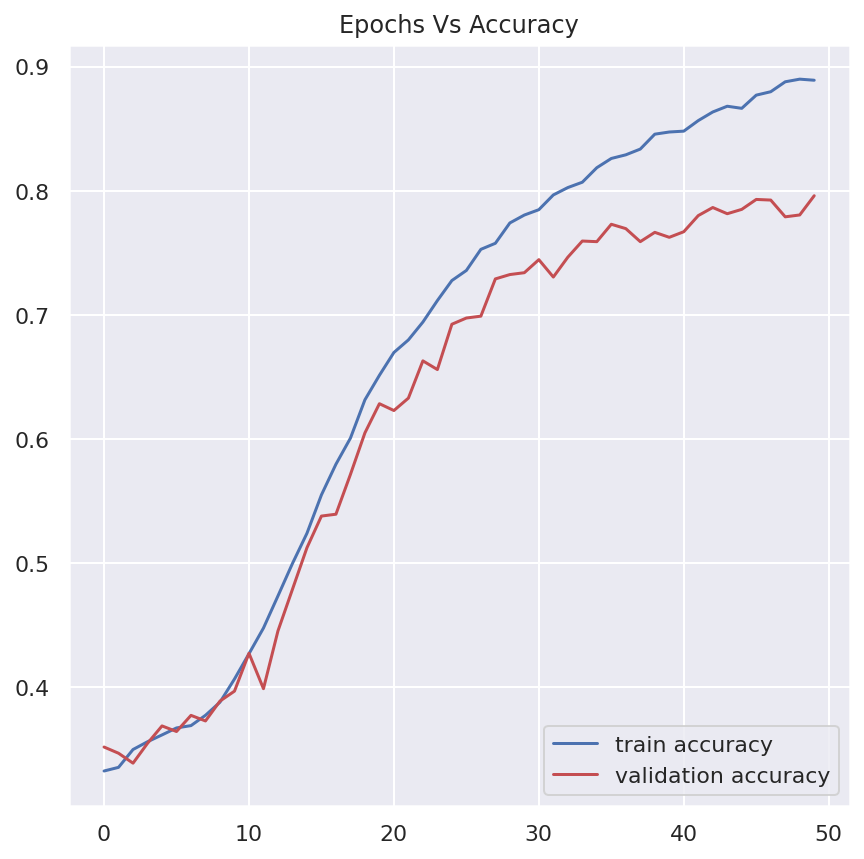

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.title("Epochs Vs Accuracy")
plt.show()

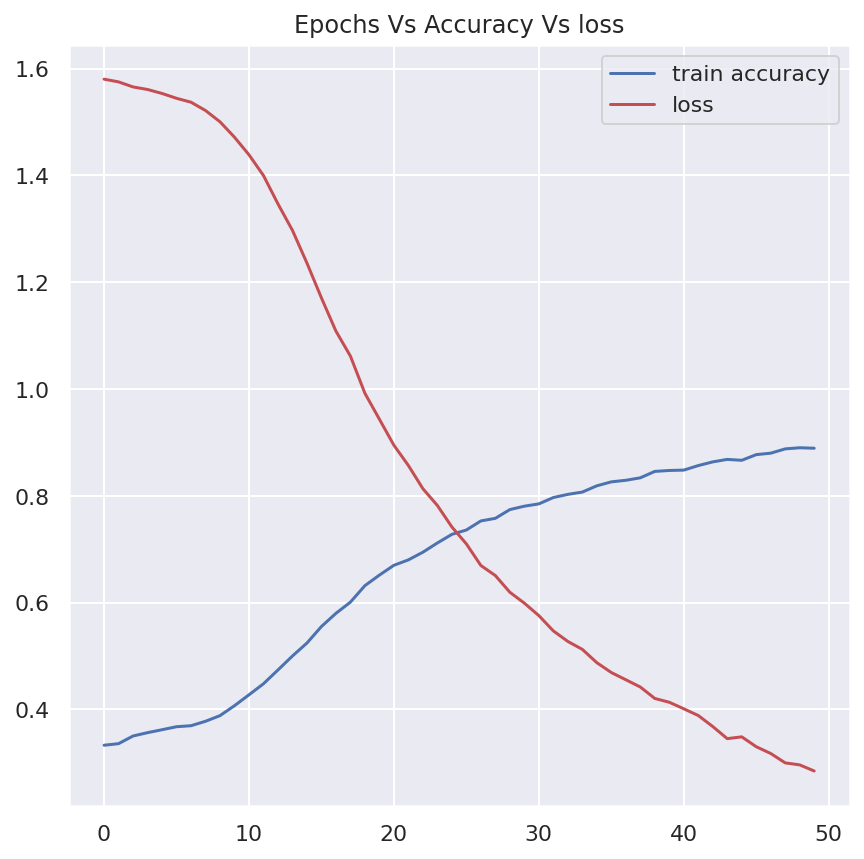

In [21]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['loss'],c='r',label='loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs Accuracy Vs loss")
plt.show()

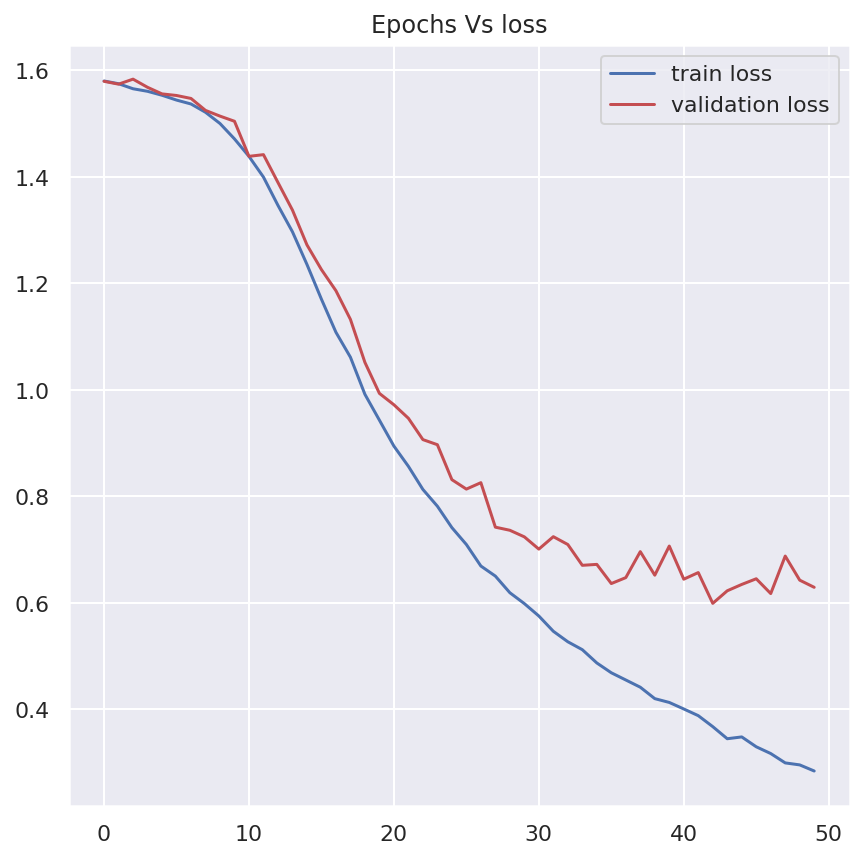

In [22]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs loss")
plt.show()

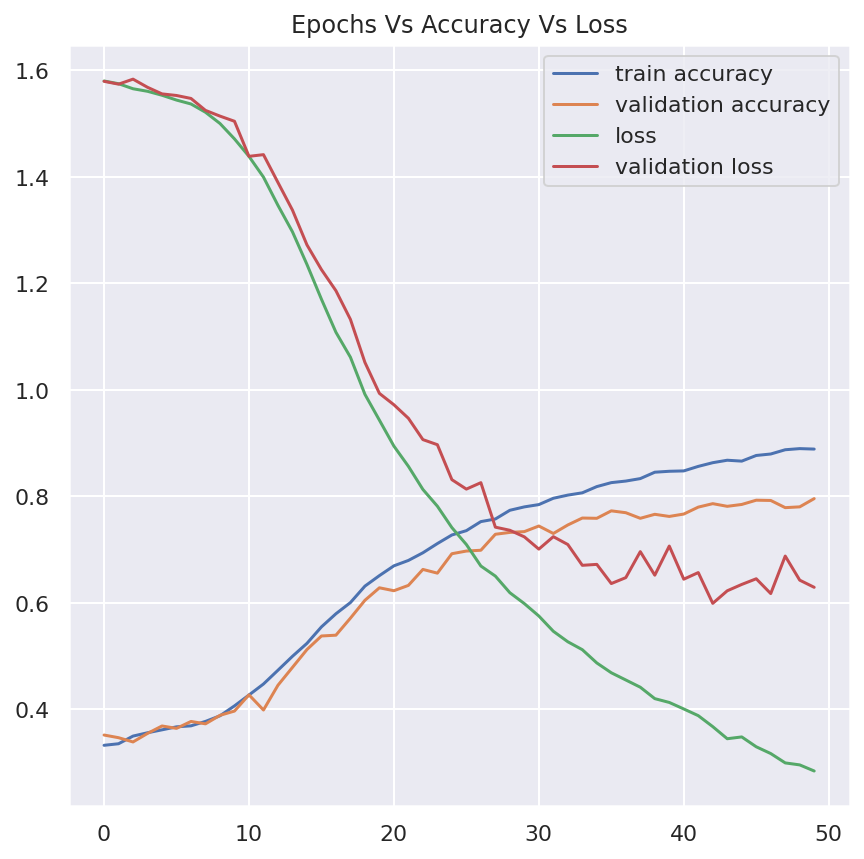

In [23]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],label='validation accuracy')
plt.plot(history_embedding.history['loss'],label='loss')
plt.plot(history_embedding.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs Accuracy Vs Loss")
plt.show()

In [24]:
model.evaluate(X_test_pad, y_test)

63/63 [==============================] - 3s 36ms/step - loss: 0.6089 - accuracy: 0.7885


[0.6088621616363525, 0.7885000109672546]

In [25]:
y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)

63/63 [==============================] - 3s 33ms/step


In [26]:
y_true = np.argmax(y_test, axis = 1)

In [27]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       695
           1       0.84      0.67      0.75       275
           2       0.69      0.57      0.63       159
           3       0.82      0.83      0.83       581
           4       0.79      0.83      0.81       224
           5       0.67      0.68      0.68        66

    accuracy                           0.79      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.79      0.79      0.79      2000



In [28]:
model.save('bi-lstm-bert_embedding_classification.h5')

In [29]:
get_label = {val : key for key, val in labels.items()}
get_label

{0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}

In [30]:
def predict(sentence: str, model):
    get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded = pad_sequences(sentence_seq, maxlen=300, padding='post')    
    pred = get_label[np.argmax(model.predict(sentence_padded))]
    print(f'{sentence} : {pred}')

In [31]:
predict("i feel so threatened", model)

1/1 [==============================] - 0s 110ms/step
i feel so threatened : fear


In [32]:
tests = [
    'i am so lucky to get placed in my favourite company',
    'i hate that person. he is so rude to me for no reason',
    'i feel down. i could not cover the whole syllabus',
    'i feel so threatened',
    'to my utter surprise, he actually cleared the exam'
]

for e in tests:
    predict(e, model)

1/1 [==============================] - 0s 17ms/step
i am so lucky to get placed in my favourite company : joy
1/1 [==============================] - 0s 17ms/step
i hate that person. he is so rude to me for no reason : anger
1/1 [==============================] - 0s 15ms/step
i feel down. i could not cover the whole syllabus : sadness
1/1 [==============================] - 0s 16ms/step
i feel so threatened : fear
1/1 [==============================] - 0s 14ms/step
to my utter surprise, he actually cleared the exam : fear


In [33]:
def batch_predict(sentence: str, model):
    get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded = pad_sequences(sentence_seq, maxlen=300, padding='post')    
    pred = np.argmax(model.predict(sentence_padded, verbose=0))
    return pred

In [34]:
test_df_actual_labels = df_test.Sentiment.tolist()

In [35]:
test_df_inputs = df_test.Input.tolist()

In [36]:
test_preds = [batch_predict(i, model) for i in test_df_inputs]

In [37]:
get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
class_names = [get_label[i] for i in range(6)]

In [38]:
df_test_comparision_df = df_test.copy()
df_test_comparision_df

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,3
1,im updating my blog because i feel shitty,3
2,i never make her separate from me because i do...,3
3,i left with my bouquet of red and yellow tulip...,0
4,i was feeling a little vain when i did this one,3
...,...,...
1995,i just keep feeling like someone is being unki...,1
1996,im feeling a little cranky negative after this...,1
1997,i feel that i am useful to my people and that ...,0
1998,im feeling more comfortable with derby i feel ...,0


In [39]:
df_test_comparision_df['predicted_sentiment'] = test_preds

In [40]:
df_test_comparision_df

,Input,Sentiment,predicted_sentiment
0,im feeling rather rotten so im not very ambiti...,3,3
1,im updating my blog because i feel shitty,3,3
2,i never make her separate from me because i do...,3,3
3,i left with my bouquet of red and yellow tulip...,0,0
4,i was feeling a little vain when i did this one,3,3
...,...,...,...
1995,i just keep feeling like someone is being unki...,1,0
1996,im feeling a little cranky negative after this...,1,1
1997,i feel that i am useful to my people and that ...,0,3
1998,im feeling more comfortable with derby i feel ...,0,0


In [41]:
length = len(df_test_comparision_df)
mis_matches_inputs = []
actual_mismatch = []
predicted_mismatch = []

for i in range(length):
    if df_test_comparision_df.loc[i, 'Sentiment'] != df_test_comparision_df.loc[i, 'predicted_sentiment']:
        mis_matches_inputs.append(df_test_comparision_df.iloc[i, 0])
        actual_mismatch.append(get_label[df_test_comparision_df.loc[i, 'Sentiment']])
        predicted_mismatch.append(get_label[df_test_comparision_df.loc[i, 'predicted_sentiment']])


mis_matches = pd.DataFrame(np.column_stack([mis_matches_inputs, actual_mismatch, predicted_mismatch]), 
                               columns=['Inputs', 'Actual', 'Predicted'])

mis_matches

,Inputs,Actual,Predicted
0,i feel beautifully emotional knowing that thes...,sadness,joy
1,i pay attention it deepens into a feeling of b...,fear,joy
2,i feel like my only role now would be to tear ...,sadness,joy
3,i feel just bcoz a fight we get mad to each ot...,anger,sadness
4,i also tell you in hopes that anyone who is st...,sadness,joy
...,...,...,...
418,i feel defeated that i have to take advil agai...,sadness,joy
419,i had that kinda feeling but ignored it,sadness,joy
420,i just keep feeling like someone is being unki...,anger,joy
421,i feel that i am useful to my people and that ...,joy,sadness


In [42]:
mis_matches.Actual.value_counts()

joy         108
sadness      98
anger        90
love         68
fear         38
surprise     21
Name: Actual, dtype: int64

In [43]:
mis_matches.Predicted.value_counts()

joy         172
sadness     104
fear         50
love         40
anger        35
surprise     22
Name: Predicted, dtype: int64

In [44]:
actual_inputs_dict = dict(mis_matches.Actual.value_counts())
predicted_output_dict = dict(mis_matches.Predicted.value_counts())

In [45]:
comparision = {}

for e in actual_inputs_dict:
    comparision[e] = predicted_output_dict[e] - actual_inputs_dict[e]
comparision

{'joy': 64, 'sadness': 6, 'anger': -55, 'love': -28, 'fear': 12, 'surprise': 1}

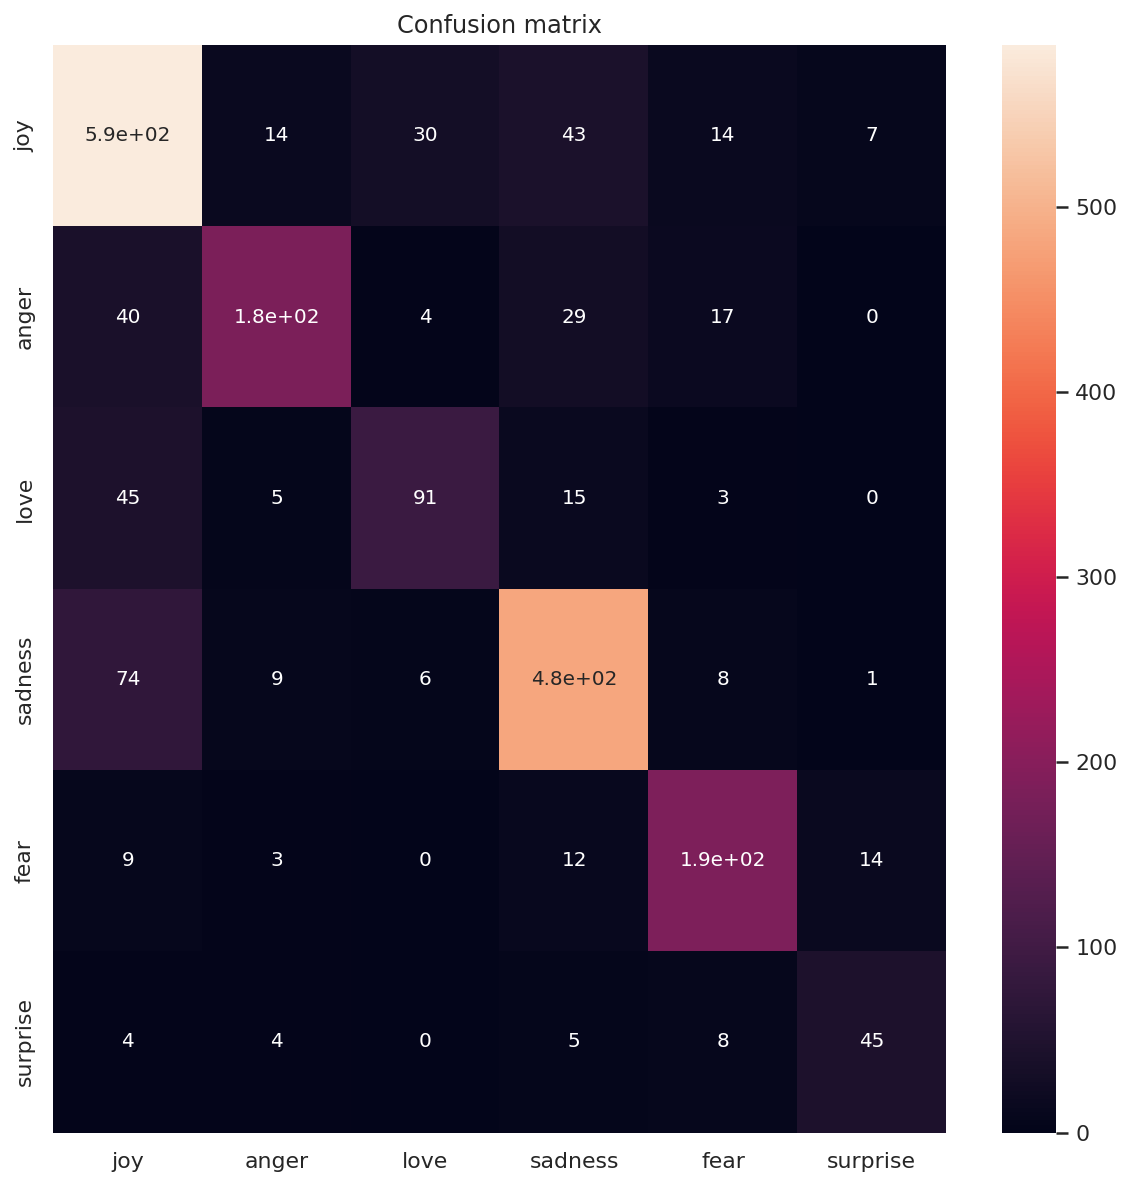

In [46]:
from sklearn.metrics import confusion_matrix

get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
class_names = get_label.values()

plt.rcParams["figure.figsize"] = (10,10)
CM = confusion_matrix(test_df_actual_labels, test_preds)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [47]:
history_embedding.history['accuracy'][-1], history_embedding.history['val_accuracy'][-1]

(0.8889999985694885, 0.7960000038146973)

In [48]:
history_embedding.history['loss'][-1], history_embedding.history['val_loss'][-1]

(0.2844294309616089, 0.6293734908103943)